In [21]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import Pitch, VerticalPitch
import numpy as np

In [2]:
# load json data
with open(r'C:\Users\RidhoBeteer\elclasico.json', encoding="utf8") as f:
    d = json.load(f)

In [3]:
# extract data from dict (credit to: https://github.com/karlosos/)
def extract_data_from_dict(data):
    match_id = data['matchId']
    event_types = data['matchCentreEventTypeJson']
    formation_mappings = data['formationIdNameMappings']
    events_dict = data['matchCentreData']['events']
    teams_dict = {
        data['matchCentreData']['home']['teamId']:data['matchCentreData']['home']['name'],
        data['matchCentreData']['away']['teamId']:data['matchCentreData']['away']['name']
    }
    players_dict = data['matchCentreData']['playerIdNameDictionary']
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df['teamId'] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df['teamId'] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df], ignore_index=True)

    return match_id, event_types, formation_mappings, events_dict, teams_dict, players_df

In [4]:
def get_match_events_list(events):
    event_list = []
    for event in events:
        event_list.append(event['type']['displayName'])

    return event_list

In [5]:
def get_events_df(events):
    df_events = pd.DataFrame(events)
    df_events['event_type'] = df_events.apply(lambda row: row['type']['displayName'], axis=1)
    df_events['outcome_type'] = df_events.apply(lambda row: row['outcomeType']['displayName'], axis=1)
    
    return df_events

In [6]:
match_id, event_types, formation_mappings, events_dict, teams_dict, players_df = extract_data_from_dict(d)

In [7]:
df_events = get_events_df(events_dict)
df_events = df_events.dropna(subset=["playerId"])
df_events['player_name'] = df_events['playerId'].map(players_df.set_index('playerId')['name'])
# df_events['matchday'] = 11
# df_events['competition'] = 'LaLiga'
df_events['opposing_team'] = df_events.apply(lambda row: 'Real Madrid' if row['teamId'] == 65 else 'Barcelona', axis=1)
df_events['isHome'] = df_events.apply(lambda row: True if row['teamId'] == 52 else False, axis=1)


In [8]:
event_types = {v: k for k, v in event_types.items()}
df_events['satisfiedEventsTypes'] = df_events['satisfiedEventsTypes'].apply(lambda x: [event_types[i] for i in x])

In [10]:
df_events.shape

(1353, 31)

In [11]:
df_events.event_type.unique()

array(['Pass', 'Aerial', 'BallRecovery', 'BlockedPass', 'BallTouch',
       'KeeperPickup', 'OffsideGiven', 'OffsidePass', 'OffsideProvoked',
       'Foul', 'CornerAwarded', 'Clearance', 'Dispossessed', 'Tackle',
       'Punch', 'Interception', 'TakeOn', 'SavedShot', 'Save',
       'MissedShots', 'Challenge', 'KeeperSweeper', 'Smother', 'Card',
       'SubstitutionOff', 'SubstitutionOn', 'Goal', 'ShotOnPost'],
      dtype=object)

In [12]:
def filter_dataframe(df, c, v):
    df_filter = df.loc[df[c] == v]
    return df_filter

In [46]:
df_recovery = filter_dataframe(df_events, 'event_type', 'BallRecovery')
df_recovery = filter_dataframe(df_recovery, 'teamId', 65)
df_recovery = df_recovery.sort_values(by=['player_name'])
recovery_players = df_recovery['player_name'].unique()
colors = ['#eedd66', '#acd7c8', '#6b7b7b', '#6a8472', '#ff9ede', '#2a7e19', '#fbedb8', '#fed0fc', '#b4e0e7', '#eaecd3', '#aa9fb2']

In [47]:
# assign color to each unique player
colors_dict = {}
for key in recovery_players:
    for value in colors:
        colors_dict[key] = value
        colors.remove(value)
        break

colors_dict

{'Alejandro Balde': '#eedd66',
 'Dani Olmo': '#acd7c8',
 'Fermín López': '#6b7b7b',
 'Iñaki Peña': '#6a8472',
 'Iñigo Martínez': '#ff9ede',
 'Jules Koundé': '#2a7e19',
 'Lamine Yamal': '#fbedb8',
 'Marc Casadó': '#fed0fc',
 'Pau Cubarsí': '#b4e0e7',
 'Pedri': '#eaecd3',
 'Raphinha': '#aa9fb2'}

In [51]:
df_recovery['color'] = df_recovery['player_name'].apply(lambda x: colors_dict.get(x))

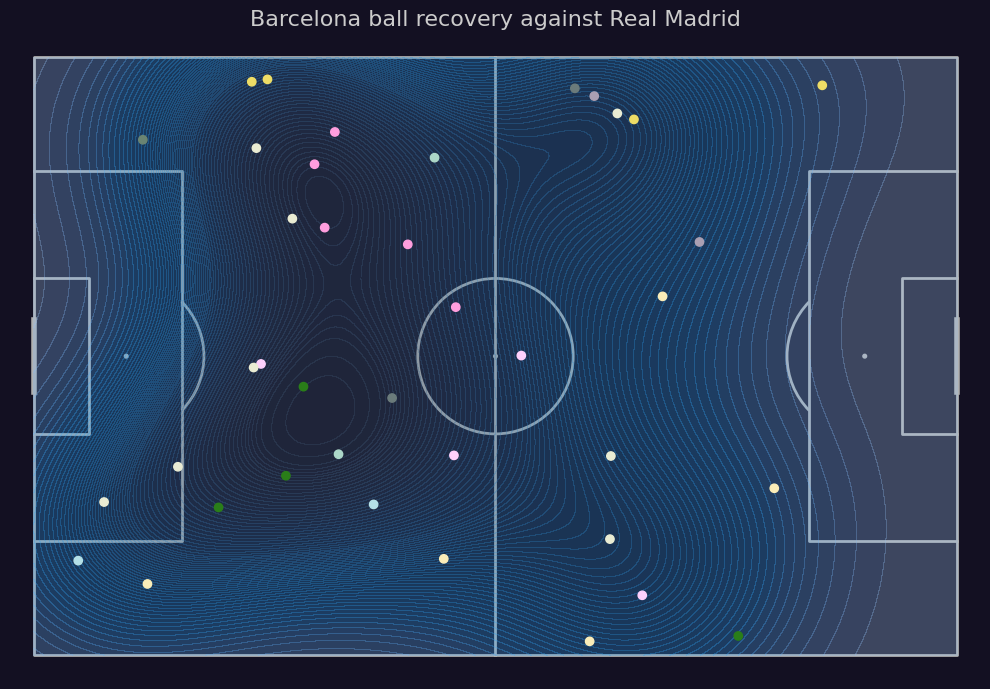

In [56]:
pitch = Pitch(pitch_type='wyscout', pitch_color='#131022')
fig, ax = pitch.draw(figsize=(11, 7), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#131022')

pitch.kdeplot(df_recovery.x, df_recovery.y, ax=ax,
              fill=True, levels=75, thresh=0,
              cut=4, alpha=0.3)
pitch.scatter(df_recovery.x, df_recovery.y, c=df_recovery.color, ax=ax)
ax_title = ax.set_title(f'Barcelona ball recovery against Real Madrid', fontsize=16, color='#ccc')
plt.gca().invert_yaxis()